Kaggle: [Heart Attack Prediction](https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset/code)

Date: 4/20/2021

In [88]:
!pip install bayesian-optimization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
plt.rcParams.update({'font.size': 13})

In [89]:
heart = pd.read_csv('/content/heart.csv')
heart.head(3)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [90]:
X = heart.drop('output', axis = 1)
X = (X-X.mean())/X.std()
y = heart['output']

In [99]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=111)

[Bayesian Optimization](https://github.com/fmfn/BayesianOptimization) of RBF kernel parameters for a Gaussian process classifier

In [100]:
class ModelSelection:
  
  def __init__(self, X_train, y_train, kernel, domain, n_iter):
    self.X = X_train
    self.y = y_train
    self.kernel = kernel
    self.domain = domain
    self.n_iter = n_iter
    self.grid = self.make_mesh()
    self.optimizer = BayesianOptimization(
        f = self.crossval, pbounds = domain, 
        random_state=1234, verbose=2)    
    self.optimize()
    self.model = self.fit_best_model()

  def make_mesh(self):
    min, max = list(self.domain.values())[0]
    return np.linspace(min, max, 100).reshape(-1,1)

  def crossval(self, sigma):
    K = self.kernel(sigma)
    GP_model = GaussianProcessClassifier(kernel = K)
    cval = cross_val_score(GP_model, self.X, self.y, scoring='roc_auc', cv=5)
    return cval.mean()

  def optimize(self):
    self.optimizer.maximize(n_iter=self.n_iter)
    self.model = self.optimizer._gp
    print("Final result:", self.optimizer.max)
  
  def posterior(self):
    mu, sigma = self.optimizer._gp.predict(self.grid, return_std=True)
    return mu, sigma

  def fit_best_model(self):
    max_params = self.optimizer.max['params']['sigma']
    K = self.kernel(max_params)
    return GaussianProcessClassifier(kernel = K).fit(self.X, self.y)

  def plot_utility(self):
    mu, sigma = self.posterior()
    vals = self.grid.T[0,:]
    plt.figure(figsize = (9,6))
    plt.plot(vals, mu, linewidth = 4, color = 'k')
    plt.fill_between(vals, mu - 3*sigma, mu + 3*sigma, color="r", alpha=0.3)
    plt.title('Utility Function')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Parameter')
    plt.show()

In [101]:
domain = {'sigma': (0.01, 1)}
M = ModelSelection(
    X_train, y_train, 
    RBF, domain, n_iter = 5)

|   iter    |  target   |   sigma   |
-------------------------------------
|  1        |  0.8964   |  0.1996   |
|  2        |  0.8964   |  0.6259   |
|  3        |  0.8964   |  0.4434   |
|  4        |  0.8964   |  0.7875   |
|  5        |  0.8964   |  0.7822   |
|  6        |  0.82     |  0.07603  |
|  7        |  0.8964   |  1.0      |
|  8        |  0.8964   |  0.306    |
|  9        |  0.8964   |  0.9096   |
|  10       |  0.8964   |  0.5334   |
Final result: {'target': 0.8963890746934225, 'params': {'sigma': 0.19960425587510336}}


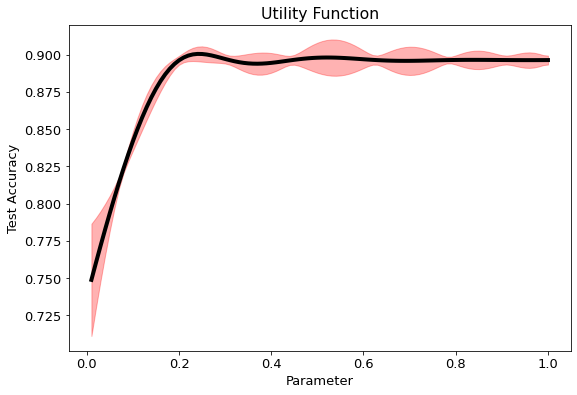

In [102]:
M.plot_utility()

In [103]:
results = X_test.copy()
preds = M.model.predict(X_test)
probs = M.model.predict_proba(X_test)[:,0]

gp_acc = sum(preds == y_test)/len(y_test)
results.loc[:,'preds'] = preds
results.loc[:,'probs'] = probs
results.loc[:,'labels'] = y_test

print('Gaussian Process Accuracy:', round(gp_acc, 4))

Gaussian Process Accuracy: 0.918


In [149]:
def plot_covariates(df, col1, col2, split = 'test'):
  if split == 'test':
    scale = 225
    t = df.query('preds == 1')
    f = df.query('preds == 0')
    misclass = df.query('preds != labels') 

    I0, J0 = 3, 7
    n = 3
    fig, ax = plt.subplots(2,3, figsize = (14,8), sharey = True, sharex = True)
    for i in range(n-1):
      for j in range(n):
        c1 = df.columns[I0+i]
        c2 = df.columns[J0+j]
        ax[i,j].scatter(t[c1], t[c2], s = t['probs']*scale, 
                color = '#3378a6', label = 'True', alpha = .75)
        ax[i,j].scatter(t[c1], t[c2], s = t['probs']*scale, 
                    color = '#3378a6', label = 'True', alpha = .75)
        ax[i,j].scatter(f[c1], f[c2], s = f['probs']*scale, 
                    color = '#ad2617', label = 'False', alpha = .75)
        ax[i,j].set_xlabel(c1)
        ax[i,j].set_ylabel(c2)
        ax[i,j].scatter(misclass[c1], misclass[c2], s = 300, marker='x', 
                    color = 'k', label = 'incorrect', alpha = .75)
    fig.suptitle('Out of Sample Predictions / Miss-Classifications') # or plt.suptitle('Main title')
    plt.show()
  elif split == 'train':
    scale = 150
    t = df.query('true_label == 1')
    f = df.query('true_label == 0')
    plt.figure(figsize = (6,4))
    plt.scatter(t[col1], t[col2], s = 100, color = '#3378a6', label = 'True', alpha = .75)
    plt.scatter(f[col1], f[col2], s = 100, color = '#ad2617', label = 'False', alpha = .75)
    plt.title('Train Data')
    plt.legend()
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.xlim([-3.75, 3.75])
    plt.ylim([-3.75, 3.75])
    plt.show()

In [150]:
X_train['true_label'] = y
X.columns.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall'], dtype=object)

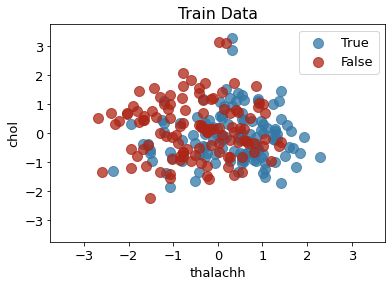

In [151]:
plot_covariates(X_train, 'thalachh', 'chol', 'train')

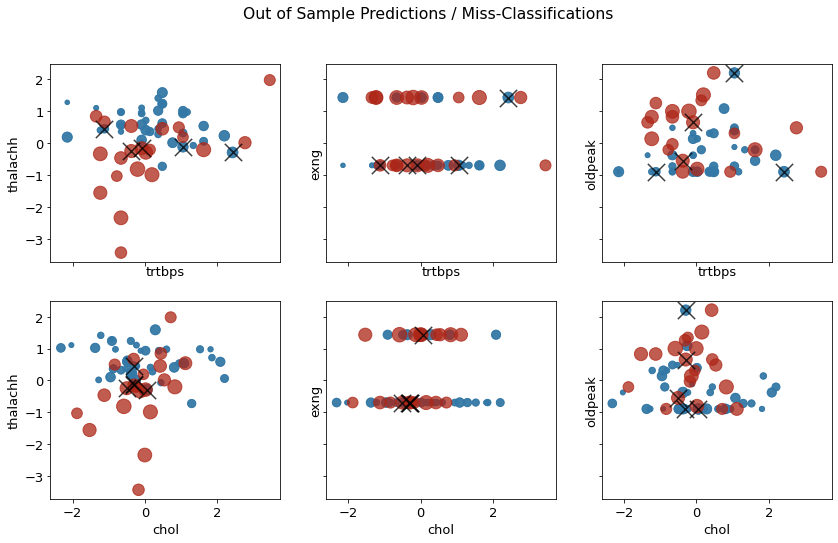

In [152]:
plot_covariates(results, None, None, 'test')